In [1]:
import json
import glob
import json_lines
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import os
import nltk
from nltk.corpus import stopwords
import string
from gensim import utils
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec
from sklearn.naive_bayes import GaussianNB
from nltk.tokenize import word_tokenize 
import warnings
warnings.filterwarnings('ignore')



In [2]:
#Load all jason files
PolitifactData = []
for f in glob.glob("C:/Users/Max/Desktop/PROJECT/DataSets/DataUni/politifact/SeparateJsonFiles/*.json"):
    with open(f, "rb") as infile:
        PolitifactData.append(json.load(infile))

In [3]:
#Converting Json to Pandas Dataframe
PolitifactData = pd.DataFrame.from_dict(PolitifactData, orient='columns')

In [4]:
#Removing spaces from collum names 
PolitifactData.columns = [c.replace(' ', '') for c in PolitifactData.columns]

In [5]:
PolitifactData.head()

,Credibility,Description,EditedBy,Published,ReferredLinks,ResearchBy,SearchResults,Sources,Speaker,Statement,StatementMetadata,Subjects,URL
0,Half-True,Rudy Giuliani has repeatedly said that he cut ...,Bill Adair,"Tuesday, October 9th, 2007 at 12:00 a.m.",,Angie Drobnic Holan,[{'url': 'http://www.nytimes.com/2007/01/17/ny...,"[{'Source Description': '""Rudy defends tax cut...",Rudy Giuliani,"""I cut taxes 23 times when I was mayor of New ...","Rudy Giuliani on Tuesday, October 9th, 2007 in...",Taxes,www.politifact.com/truth-o-meter/statements/109/
1,Half-True,"In a TV ad airing in Iowa and New Hampshire, S...",Bill Adair,"Monday, October 8th, 2007 at 12:00 a.m.",,Angie Drobnic Holan,[{'url': 'http://www.washingtonpost.com/wp-dyn...,"[{'Source Description': 'The Associated Press,...",Hillary Clinton,"""Hillary stood up for universal health care wh...","Hillary Clinton on Thursday, October 4th, 2007...",Health Care,www.politifact.com/truth-o-meter/statements/112/
2,Mostly True,"Among the field of Democratic candidates, Sen....",Scott Montgomery,"Wednesday, October 17th, 2007 at 12:00 a.m.",,Angie Drobnic Holan,[{'url': 'https://www.washingtonpost.com/wp-dy...,[{'Source Description': 'Joe Biden campaign we...,Joe Biden,"""First, he was in favor of my plan, now he's a...","Joe Biden on Friday, October 12th, 2007 in",Iraq,www.politifact.com/truth-o-meter/statements/126/
3,Mostly True,"On ethanol, McCain has maintained a long-stand...",Bill Adair,"Thursday, August 23rd, 2007 at 12:00 a.m.",,Angie Drobnic Holan,[{'url': 'http://grist.org/article/mccain_fact...,[],Mitt Romney,"""(McCain) was opposed to ethanol. Now he's for...","Mitt Romney on Thursday, April 26th, 2007 in S...",Energy,www.politifact.com/truth-o-meter/statements/13/
4,True,Romney is right that McCain switched on the ta...,Bill Duryea,"Wednesday, September 5th, 2007 at 12:00 a.m.",,Angie Drobnic Holan,[{'url': 'https://www.senate.gov/?congress=107...,"[{'Source Description': '', 'Source URL': ''}]",Mitt Romney,"""Senator McCain voted against the Bush tax cut...","Mitt Romney on Thursday, April 26th, 2007 in S...",Taxes,www.politifact.com/truth-o-meter/statements/14/


In [6]:
# #Dropping unnecessary colums
PolitifactData = PolitifactData.drop(['ReferredLinks'],axis=1)
PolitifactData = PolitifactData.drop(['Published'], axis=1)
PolitifactData = PolitifactData.drop(['StatementMetadata'], axis=1)
PolitifactData = PolitifactData.drop(['URL'], axis=1)
PolitifactData = PolitifactData.drop(['EditedBy'], axis=1)
PolitifactData = PolitifactData.drop(['ResearchBy'], axis=1)
PolitifactData = PolitifactData.drop(['Sources'], axis=1)




In [7]:
#Delete records with empty list values
Features = PolitifactData.keys()
for colName in Features:
    PolitifactData = PolitifactData[PolitifactData[colName].apply(len) > 0]
    PolitifactData[colName].replace("", np.nan, inplace=True) 

In [8]:
#Show which recors have na values
PolitifactData[PolitifactData.isnull().any(axis=1)]

,Credibility,Description,SearchResults,Speaker,Statement,Subjects


In [9]:
#Drom na values
PolitifactData = PolitifactData.dropna()

In [10]:
# Find Missing Ratio of Dataset
all_data_na = (PolitifactData.isnull().sum() / len(PolitifactData)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]

missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

,Missing Ratio


In [11]:
PolitifactData.head()

,Credibility,Description,SearchResults,Speaker,Statement,Subjects
0,Half-True,Rudy Giuliani has repeatedly said that he cut ...,[{'url': 'http://www.nytimes.com/2007/01/17/ny...,Rudy Giuliani,"""I cut taxes 23 times when I was mayor of New ...",Taxes
1,Half-True,"In a TV ad airing in Iowa and New Hampshire, S...",[{'url': 'http://www.washingtonpost.com/wp-dyn...,Hillary Clinton,"""Hillary stood up for universal health care wh...",Health Care
2,Mostly True,"Among the field of Democratic candidates, Sen....",[{'url': 'https://www.washingtonpost.com/wp-dy...,Joe Biden,"""First, he was in favor of my plan, now he's a...",Iraq
3,Mostly True,"On ethanol, McCain has maintained a long-stand...",[{'url': 'http://grist.org/article/mccain_fact...,Mitt Romney,"""(McCain) was opposed to ethanol. Now he's for...",Energy
4,True,Romney is right that McCain switched on the ta...,[{'url': 'https://www.senate.gov/?congress=107...,Mitt Romney,"""Senator McCain voted against the Bush tax cut...",Taxes


In [12]:
#Printing all features
PolitifactData.keys()

Index(['Credibility', 'Description', 'SearchResults', 'Speaker', 'Statement',
       'Subjects'],
      dtype='object')

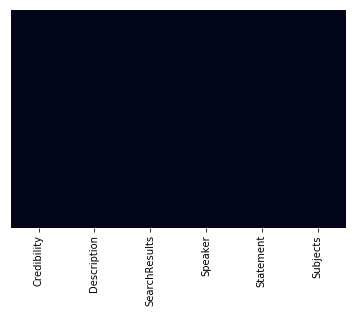

In [13]:
#Check for null values
sns.heatmap(PolitifactData.isnull(),yticklabels=False,cbar=False)

In [14]:
PolitifactData.isnull().any()

Credibility      False
Description      False
SearchResults    False
Speaker          False
Statement        False
Subjects         False
dtype: bool

In [15]:
#Checking unique labels
UniqueCredibility = pd.Series(PolitifactData["Credibility"], name='A').unique()
UniqueCredibility

array(['Half-True', 'Mostly True', 'True', 'False', 'Pants on Fire!',
       'Mostly False', 'Full Flop', 'Half Flip', 'No Flip'], dtype=object)

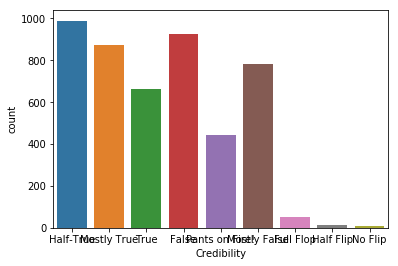

In [16]:
sns.countplot(x='Credibility',data=PolitifactData)

In [17]:
#Removing unnesesary labels
PolitifactData = PolitifactData[PolitifactData.Credibility != "Half Flip"]
PolitifactData = PolitifactData[PolitifactData.Credibility != "No Flip"]
PolitifactData = PolitifactData[PolitifactData.Credibility != "Full Flop"]


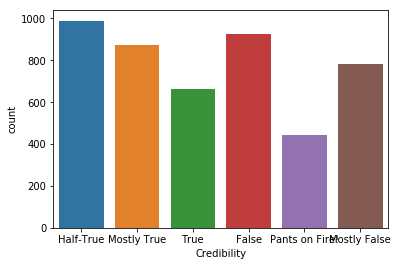

In [18]:
sns.countplot(x='Credibility',data=PolitifactData)

In [19]:
def impute_credibility(Cred):    
    
    if Cred == "True":
        return "True"
    
    elif Cred == "Mostly True":
        return "True"
    
    elif Cred == "Half-True":
        return "True"
    
    elif Cred == "False":
        return "False"
    
    elif Cred == 'Mostly False':
        return "False"
    
    elif Cred == 'Pants on Fire!':
        return "False"



In [20]:
#Convert 6 labels to 2
PolitifactData['Credibility'] = PolitifactData['Credibility'].apply(impute_credibility)

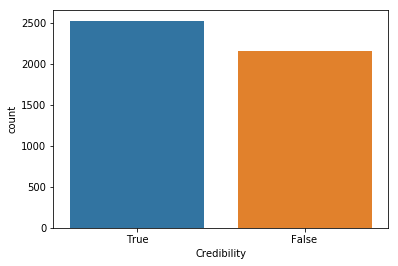

In [21]:
sns.countplot(x='Credibility',data=PolitifactData)

In [22]:
print(PolitifactData.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4677 entries, 0 to 4756
Data columns (total 6 columns):
Credibility      4677 non-null object
Description      4677 non-null object
SearchResults    4677 non-null object
Speaker          4677 non-null object
Statement        4677 non-null object
Subjects         4677 non-null object
dtypes: object(6)
memory usage: 415.8+ KB
None


In [23]:
PolitifactData = PolitifactData.reset_index(drop=True)

In [24]:
PolitifactData.head()


,Credibility,Description,SearchResults,Speaker,Statement,Subjects
0,True,Rudy Giuliani has repeatedly said that he cut ...,[{'url': 'http://www.nytimes.com/2007/01/17/ny...,Rudy Giuliani,"""I cut taxes 23 times when I was mayor of New ...",Taxes
1,True,"In a TV ad airing in Iowa and New Hampshire, S...",[{'url': 'http://www.washingtonpost.com/wp-dyn...,Hillary Clinton,"""Hillary stood up for universal health care wh...",Health Care
2,True,"Among the field of Democratic candidates, Sen....",[{'url': 'https://www.washingtonpost.com/wp-dy...,Joe Biden,"""First, he was in favor of my plan, now he's a...",Iraq
3,True,"On ethanol, McCain has maintained a long-stand...",[{'url': 'http://grist.org/article/mccain_fact...,Mitt Romney,"""(McCain) was opposed to ethanol. Now he's for...",Energy
4,True,Romney is right that McCain switched on the ta...,[{'url': 'https://www.senate.gov/?congress=107...,Mitt Romney,"""Senator McCain voted against the Bush tax cut...",Taxes


In [25]:
#Substitute True with 1 and False with 0
PolitifactData["Credibility"].replace("True", 1, inplace=True)
PolitifactData["Credibility"].replace("False", 0, inplace=True)


In [26]:
# for RecordID in range(len(PolitifactData.SearchResults)):
#     RecordText = []
#     for Doc_Text in range(len(PolitifactData.SearchResults[RecordID])):
#         print(Doc_Text)
#         for key, value in PolitifactData.SearchResults[RecordID][Doc_Text].items():
#                 if key == "doc_text":
#                     RecordText.append(value)
#     PolitifactData.SearchResults[RecordID] = RecordText

In [27]:
def Preprocessing1(text):  # for description
    text = re.sub(r"[^A-Za-z0-9^]", " ", text)
    text = text.lower().split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

In [28]:
def Preprocessing2(text):  # for search result
    text = ','.join(str(v) for v in text)
    text = re.sub(r"[^A-Za-z0-9^]", " ", text)      
    text = text.lower().split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

In [29]:
def Preprocessing(text):
    if type(text) is list:
        text = ','.join(str(v) for v in text)

    cleaned_text = text.lower()
    for char in ["\n", "\t", "\r"]:
        cleaned_text = cleaned_text.replace(char, " ")
    cleaned_text = cleaned_text.encode("ascii", "ignore").decode("ascii")
    cleaned_text = re.sub(r"[^\w\s]", "", cleaned_text)
    #text = re.sub(r"[^A-Za-z0-9^$]", " ", text)  
    tokenized_text = cleaned_text.split()
    stops = set(stopwords.words("english"))
    stop_text = [w for w in tokenized_text if not w in stops]
    text = [w for w in stop_text if len(w)>2]
    text = " ".join(text)
    
    words = set(nltk.corpus.words.words())
    result = " ".join(w for w in nltk.wordpunct_tokenize(text) if w in words)
    
    return result

In [30]:
for i in range(len(PolitifactData)):
    PolitifactData.loc[i, 'SearchResults'] = Preprocessing(PolitifactData.loc[i, 'SearchResults'])
    PolitifactData.loc[i, 'Statement'] = Preprocessing(PolitifactData.loc[i, 'Statement'])
    PolitifactData.loc[i, 'Description'] = Preprocessing(PolitifactData.loc[i, 'Description'])
    

In [31]:
PolitifactData.isnull().any()

Credibility      False
Description      False
SearchResults    False
Speaker          False
Statement        False
Subjects         False
dtype: bool

In [32]:
PolitifactData.head()

,Credibility,Description,SearchResults,Speaker,Statement,Subjects
0,1,repeatedly said cut times mayor new york repea...,[{'url': 'http://www.nytimes.com/2007/01/17/ny...,Rudy Giuliani,"""I cut taxes 23 times when I was mayor of New ...",Taxes
1,1,airing new sen leader health care stood univer...,[{'url': 'http://www.washingtonpost.com/wp-dyn...,Hillary Clinton,"""Hillary stood up for universal health care wh...",Health Care
2,1,among field democratic sen joe detailed plan e...,[{'url': 'https://www.washingtonpost.com/wp-dy...,Joe Biden,"""First, he was in favor of my plan, now he's a...",Iraq
3,1,ethanol opposition alternative fuel way ethano...,[{'url': 'http://grist.org/article/mccain_fact...,Mitt Romney,"""(McCain) was opposed to ethanol. Now he's for...",Energy
4,1,right switched tax first voting time said tax ...,[{'url': 'https://www.senate.gov/?congress=107...,Mitt Romney,"""Senator McCain voted against the Bush tax cut...",Taxes


In [57]:
#Create a csv file from the jason files
export_csv = PolitifactData.to_csv (r"C:/Users/Max/Desktop/PROJECT/DataSets/PolitDataPrepFiltered.csv", index = None, header=True) 